In [1]:
import tensorflow as tf
import torch 
import Bio.SeqIO as SeqIO
from transformers import BertTokenizer, BertForSequenceClassification
import pickle
import random
import numpy as np
import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

2024-01-24 19:14:43.704121: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 19:14:43.704239: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 19:14:43.704303: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 19:14:43.719819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the trained Hybrid NN

In [2]:
# Load the models
all_seq_NN = tf.keras.models.load_model('/data/xhorvat9/ltr_bert/NewClassifiers/LTR_classifier/NN/all_length_cnn_lstm.h5') 

2024-01-24 19:15:00.512219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-24 19:15:00.514378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79087 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:61:00.0, compute capability: 8.0
2024-01-24 19:15:01.081819: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


## Load the finetuned DNABERT model

In [2]:

KMER = 6
STRIDE_SIZE = 1

tokenizer = BertTokenizer.from_pretrained(f'zhihan1996/DNA_bert_6')
model = BertForSequenceClassification.from_pretrained("/data/xhorvat9/ltr_bert/NewClassifiers/LTR_classifier/BERT/LTRBERT_LTR_classifier_512")
model.eval()

if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
model.to(device)

def Kmers_funct(seq, size=6, stride=1):
   return [seq[x:x+size].upper() for x in range(0, len(seq) - size + 2, stride)]
def tok_func(x, size=6, stride=1): return " ".join(Kmers_funct(x.replace("N", ""), size=size, stride=stride))

# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

## Load the trained GB classifier

In [3]:
import pickle
GBC = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/LTR_classifier/TFBS/GBC_pipeline.b", "rb"))

/var/tmp/xhorvat9/tf_CUDA/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/tmp/xhorvat9/tf_CUDA/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DummyClassifier from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/tmp/xhorvat9/tf_CUDA/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.0 when using

## Test on short sequences (within 512bps)

In [119]:

MAX_LEN=512
MIN_LEN=0
random.seed(42)
LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/test_LTRs.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN]
n_sequences = len(LTRs)

generated, genomic, markov = int(n_sequences*0.2), int(n_sequences*0.4), int(n_sequences*0.4)

# Load non-LTR sequences and subsample down to the same number of sequences as LTRs
genomic_non_LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/non_LTRs_test_genomic_extracts.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN]
if genomic < len(genomic_non_LTRs):
    genomic_non_LTRs = random.sample(genomic_non_LTRs, genomic)
generated_non_LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/non_LTRs_test_generated.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN]
if generated < len(generated_non_LTRs):
    generated_non_LTRs = random.sample(generated_non_LTRs, generated)
markov_non_LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/non_LTRs_test_markovChain.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN]
if markov < len(markov_non_LTRs):
    markov_non_LTRs = random.sample(markov_non_LTRs, markov)
non_LTRs = genomic_non_LTRs + generated_non_LTRs + markov_non_LTRs

labels = [0]*len(non_LTRs) + [1]*len(LTRs)

In [97]:
Y_short = labels

### LTRBERT
- tokenize
- encode
- run predictions

In [5]:
from transformers import Trainer
sequences = [str(rec.seq) for rec in non_LTRs+LTRs]

data = Dataset(tokenizer([tok_func(x, int(KMER), STRIDE_SIZE) for x in sequences], padding=True, truncation=True, max_length=512), labels)
trainer = Trainer(model)
raw_pred, _, _ = trainer.predict(data) # Preprocess raw predictions
BERT_short_predictions = np.argmax(raw_pred, axis=1)

/var/tmp/xhorvat9/LTRBERT/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [6]:
np.save("BERT_predict_probas_short.npy", raw_pred)
np.save("BERT_predictions_short.npy", BERT_short_predictions)

### CNN-LSTM
- encode
- pad
- run predictions

In [4]:
import numpy as np
from utils.CNN_utils import *

In [8]:
sequences = [onehote(remove_N(str(rec.seq))) for rec in tqdm.tqdm(non_LTRs+LTRs)]
paddedDNA = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding="pre", maxlen=3000)
Hybrid_NN_long_predict_probas = all_seq_NN.predict(paddedDNA)
Hybrid_NN_long_predictions = ((Hybrid_NN_long_predict_probas > 0.5)+0).ravel()

100%|██████████| 45595/45595 [00:10<00:00, 4402.53it/s]
2024-01-24 15:43:08.043414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-24 15:43:08.166101: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1425/1425 [==============================] - 17s 11ms/step


In [9]:
np.save("Hybrid_NN_short_predictions.npy", Hybrid_NN_long_predictions)
np.save("Hybrid_NN_short_predict_probas.npy", Hybrid_NN_long_predict_probas)

## GBC

In [8]:
test_LTR_motifs = pickle.load(open("/data/xhorvat9/ltr_bert/Simple_ML_model/test_LTR_TFBS_old638.b", "rb"))
test_non_LTR_motifs = pickle.load(open("/data/xhorvat9/ltr_bert/Simple_ML_model/test_non_LTR_TFBS_long.b", "rb"))

In [120]:
from utils.TFBS_utils import get_presence_count_dict

# Load the LTR and non-LTR motifs
LTR_motif_dict_count = dict([(key, []) for key in test_LTR_motifs[list(test_LTR_motifs.keys())[0]]])
LTR_motif_dict_presence = dict([(key, []) for key in test_LTR_motifs[list(test_LTR_motifs.keys())[0]]])
get_presence_count_dict(LTR_motif_dict_count, LTR_motif_dict_presence, test_LTR_motifs)

IDs = list(test_LTR_motifs.keys())
LTR_dt = pd.DataFrame(LTR_motif_dict_count, index=IDs)

non_LTR_motif_dict_count = dict([(key, []) for key in test_non_LTR_motifs[list(test_non_LTR_motifs.keys())[0]]])
non_LTR_motif_dict_presence = dict([(key, []) for key in test_non_LTR_motifs[list(test_non_LTR_motifs.keys())[0]]])
get_presence_count_dict(non_LTR_motif_dict_count, non_LTR_motif_dict_presence, test_non_LTR_motifs)

IDs = list(test_non_LTR_motifs.keys())
non_LTR_dt = pd.DataFrame(non_LTR_motif_dict_count, index=IDs)

labels = [0] * len(non_LTR_dt) + [1] * len(LTR_dt) 
data = pd.concat([non_LTR_dt, LTR_dt], axis=0)
data["class"] = labels

Match to sequence IDS below 512 bps

In [121]:
records = LTRs + non_LTRs
rec_ids = pd.DataFrame({"ID": [rec.id for rec in records]})
test_data_short = rec_ids.join(data, how = "inner", on = "ID")
Y = test_data_short["class"]
X = test_data_short.drop(["ID", "class"], axis=1)

In [122]:
Y_short_GBC = Y

In [20]:
GBC_predict_probas = GBC.predict_proba(X)
GBC_predictions = GBC.predict(X)

In [21]:
GBC.score(X, Y)

0.7353218554666082

In [22]:
np.save("GBC_predict_probas_short.npy", GBC_predict_probas)
np.save("GBC_predictions_short.npy", GBC_predictions)

In [24]:
np.save("Y_short.npy", Y_short)

NameError: name 'Y_short' is not defined

## Evaluate on short sequences
- Accuracy
- Sensitivity
- Specificity
- MCC
- ROC-AUC
- confusion matrix

In [23]:
from sklearn.metrics import f1_score
Y = [0]*len(non_LTRs) + [1]*len(LTRs)
# Calculate accuracy
accuracy = accuracy_score(Y, Hybrid_NN_short_predictions)

# Calculate sensitivity (recall)
sensitivity = recall_score(Y, Hybrid_NN_short_predictions)

# Calculate specificity
specificity = recall_score(Y, Hybrid_NN_short_predictions, pos_label=0)

# Calculate MCC
mcc = matthews_corrcoef(Y, Hybrid_NN_short_predictions)

# Calculate ROC-AUC
roc_auc = roc_auc_score(Y, Hybrid_NN_short_predictions)

# Calculate confusion matrix
cm = confusion_matrix(Y, Hybrid_NN_short_predictions)

# Calculate F1 score
f1 = f1_score(Y, Hybrid_NN_short_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
g.set_xticklabels(["Non-LTR", "LTR"])
g.set_yticklabels(["Non-LTR", "LTR"])
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y, Hybrid_NN_short_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

NameError: name 'Hybrid_NN_short_predictions' is not defined

In [15]:
accuracy_formatted = format(accuracy, ".2f")
sensitivity_formatted = format(sensitivity, ".2f")
specificity_formatted = format(specificity, ".2f")
f1_formatted = format(f1, ".2f")

print("Hybrid CNN model results:")
print("Accuracy: {}".format(accuracy_formatted))
print("Sensitivity: {}".format(sensitivity_formatted))
print("Specificity: {}".format(specificity_formatted))
print("F1 Score: {}".format(f1_formatted))


Hybrid CNN model results:
Accuracy: 0.82
Sensitivity: 0.89
Specificity: 0.75
F1 Score: 0.83


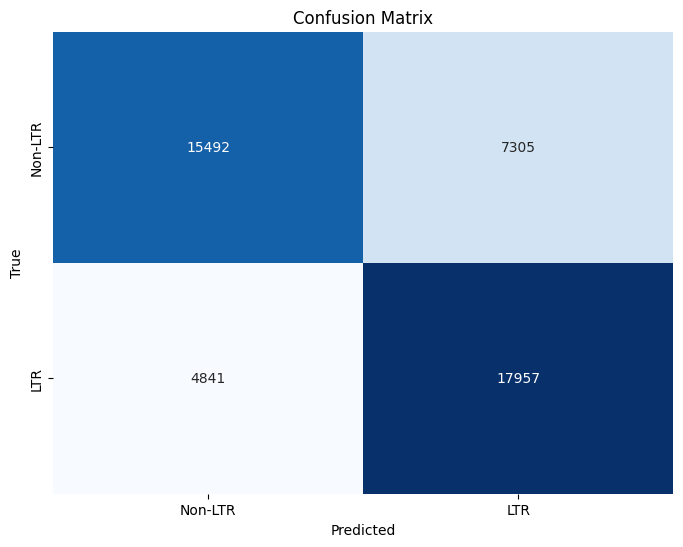

GBC model results:
Accuracy: 0.73
Sensitivity: 0.79
Specificity: 0.68
F1 Score: 0.75


In [16]:

Y = test_data_short["class"]
# Calculate accuracy
accuracy = accuracy_score(Y, GBC_predictions)

# Calculate sensitivity (recall)
sensitivity = recall_score(Y, GBC_predictions)

# Calculate specificity
specificity = recall_score(Y, GBC_predictions, pos_label=0)

# Calculate MCC
mcc = matthews_corrcoef(Y, GBC_predictions)

# Calculate ROC-AUC
roc_auc = roc_auc_score(Y, GBC_predictions)

# Calculate confusion matrix
cm = confusion_matrix(Y, GBC_predictions)

f1 = f1_score(Y, GBC_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
g.set_xticklabels(["Non-LTR", "LTR"])
g.set_yticklabels(["Non-LTR", "LTR"])
plt.show()

accuracy_formatted = format(accuracy, ".2f")
sensitivity_formatted = format(sensitivity, ".2f")
specificity_formatted = format(specificity, ".2f")
f1_formatted = format(f1, ".2f")

print("GBC model results:")
print("Accuracy: {}".format(accuracy_formatted))
print("Sensitivity: {}".format(sensitivity_formatted))
print("Specificity: {}".format(specificity_formatted))
print("F1 Score: {}".format(f1_formatted))

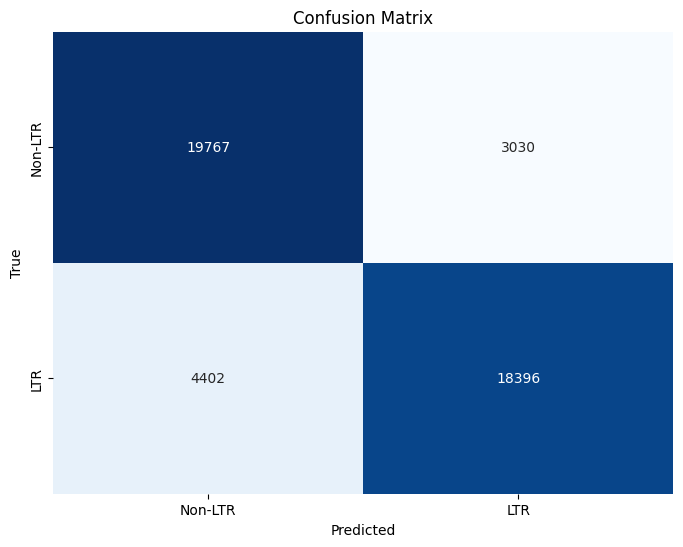

DNABERT model results:
Accuracy: 0.84
Sensitivity: 0.81
Specificity: 0.87
F1 Score: 0.83


In [17]:
Y = [0]*len(non_LTRs) + [1]*len(LTRs)
# Calculate accuracy
accuracy = accuracy_score(Y, BERT_short_predictions)

# Calculate sensitivity (recall)
sensitivity = recall_score(Y, BERT_short_predictions)

# Calculate specificity
specificity = recall_score(Y, BERT_short_predictions, pos_label=0)

# Calculate MCC
mcc = matthews_corrcoef(Y, BERT_short_predictions)

# Calculate ROC-AUC
roc_auc = roc_auc_score(Y, BERT_short_predictions)

# Calculate confusion matrix
cm = confusion_matrix(Y, BERT_short_predictions)

f1 = f1_score(Y, BERT_short_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
g.set_xticklabels(["Non-LTR", "LTR"])
g.set_yticklabels(["Non-LTR", "LTR"])
plt.show()

# Plot ROC curve
accuracy_formatted = format(accuracy, ".2f")
sensitivity_formatted = format(sensitivity, ".2f")
specificity_formatted = format(specificity, ".2f")
f1_formatted = format(f1, ".2f")

print("DNABERT model results:")
print("Accuracy: {}".format(accuracy_formatted))
print("Sensitivity: {}".format(sensitivity_formatted))
print("Specificity: {}".format(specificity_formatted))
print("F1 Score: {}".format(f1_formatted))


## Confusion matrices

In [ ]:
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calculate confusion matrix
cm = confusion_matrix(Y, GBC_predictions)
# Plot GBC results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[0], vmax=12000, vmin=1000)
axes[0].set_title('GBC Results')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Non-LTR', 'LTR'])
axes[0].set_yticklabels(['Non-LTR', 'LTR'])


cm = confusion_matrix(Y, Hybrid_NN_long_predictions)
# Plot Hybrid NN results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[1], vmax=12000, vmin=1000)
axes[1].set_title('Hybrid NN Results')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Non-LTR', 'LTR'])
axes[1].set_yticklabels(['Non-LTR', 'LTR'])

# Calculate confusion matrix
cm = confusion_matrix(labels, BERT_short_predictions)
# Plot BERT results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[2], vmax=12000, vmin=1000)
axes[2].set_title('BERT Results')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_xticklabels(['Non-LTR', 'LTR'])
axes[2].set_yticklabels(['Non-LTR', 'LTR'])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Get metrics

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef, roc_auc_score, f1_score
import matplotlib.pyplot as plt
# Create a list of predictions and labels
Y = [0]*len(non_LTRs) + [1]*len(LTRs)
predictions = [GBC_predictions, Hybrid_NN_long_predictions, BERT_short_predictions]
names = ['GBC', 'Hybrid NN', 'BERT']

# Create a list to store the metrics
accuracy_list = []
sensitivity_list = []
specificity_list = []
mcc_list = []
roc_auc_list = []
f1_list = []

# Calculate the metrics for each prediction
for pred, n in zip(predictions, names):
    if n == 'BERT':
        y = labels
    else:
        y = Y
    # Calculate accuracy
    accuracy = accuracy_score(y, pred)
    accuracy_list.append(accuracy)
    
    # Calculate sensitivity (recall)
    sensitivity = recall_score(y, pred)
    sensitivity_list.append(sensitivity)
    
    # Calculate specificity
    specificity = recall_score(y, pred, pos_label=0)
    specificity_list.append(specificity)
    
    # Calculate MCC
    mcc = matthews_corrcoef(y, pred)
    mcc_list.append(mcc)
    
    # Calculate F1 score
    f1 = f1_score(y, pred)
    f1_list.append(f1)

# Create a list of metric lists
metrics_list = [accuracy_list, sensitivity_list, specificity_list, mcc_list, f1_list]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(metrics_list, annot=True, cmap="Blues", fmt=".2f", xticklabels=names, yticklabels=['Accuracy', 'Sensitivity', 'Specificity', 'MCC', 'F1 Score'])
ax.set_title('Metrics Comparison')
ax.set_xlabel('Predictions')
ax.set_ylabel('Metrics')

# Show the plot
plt.show()

## ROC-AUC visualization 

In [ ]:
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate and true positive rate for each model
fpr_hybrid, tpr_hybrid, _ = roc_curve(Y, HNN_long_probas)
fpr_gbc, tpr_gbc, _ = roc_curve(Y, GBC.predict_proba(X)[:, 1])
fpr_bert, tpr_bert, _ = roc_curve(labels, predicted_probas_BERT)

# Calculate the area under the ROC curve for each model
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
roc_auc_bert = auc(fpr_bert, tpr_bert)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_hybrid, tpr_hybrid, label="Hybrid NN (area = %0.2f)" % roc_auc_hybrid)
plt.plot(fpr_gbc, tpr_gbc, label="GBC (area = %0.2f)" % roc_auc_gbc)
plt.plot(fpr_bert, tpr_bert, label="BERT (area = %0.2f)" % roc_auc_bert)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

## Test on long sequences (700-4000bps)

In [123]:
# Load the sequences
MAX_LEN=4000
MIN_LEN=512

LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/test_LTRs.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN]
n_sequences = len(LTRs)
random.seed(42)
generated, genomic, markov = int(n_sequences*0.2), int(n_sequences*0.4), int(n_sequences*0.4)

genomic_non_LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/non_LTRs_test_genomic_extracts.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN]
if genomic < len(genomic_non_LTRs):
    genomic_non_LTRs = random.sample(genomic_non_LTRs, genomic)
generated_non_LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/non_LTRs_test_generated.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN]
if generated < len(generated_non_LTRs):
    generated_non_LTRs = random.sample(generated_non_LTRs, generated)
markov_non_LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/non_LTRs_test_markovChain.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN]
if markov < len(markov_non_LTRs):
    markov_non_LTRs = random.sample(markov_non_LTRs, markov)
non_LTRs = genomic_non_LTRs + generated_non_LTRs + markov_non_LTRs

labels = [1]*len(LTRs) + [0]*len(non_LTRs)

In [20]:
Y_long = labels

# Load the embedding classification network 
The embedding is a timely process so the sequences have been pre-embedded for the purposes of analysis.
If no embeddings are available, set ```create_embeddings=True```

In [39]:
from classification_tools import avg_pool_embeddings
create_embeddings = False

if create_embeddings:
    avg_pool_embeddings()
else:
    embedded_test_sequences, embed_labs, seq_ids = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/LTR_classifier/BERT/LTRBERT_LTR_classifier_embeddings_TEST.b_average", "rb"))

In [ ]:
label_df = pd.DataFrame({"ID": seq_ids, "class" : labels})
label_df.index = label_df["ID"]
label_df = label_df.drop("ID", axis=1)
print(len(label_df))
ltr_df = pd.DataFrame({"ID": [rec.id for rec in non_LTRs+LTRs], "sequence" : [str(rec.seq) for rec in non_LTRs+ LTRs]}).set_index("ID")

#ltr_df = ltr_df.join(label_df, how="left")
ltr_df = pd.merge(ltr_df, label_df, left_index=True, right_index=True)
print(ltr_df)
print(len(ltr_df))
sequences = ltr_df["sequence"].tolist()

In [49]:
ltr_df["class"].value_counts()

class
0    203186
1     12562
Name: count, dtype: int64

In [50]:
new_embeds = []

for seqid in tqdm.tqdm(list(ltr_df.index)):
    for embed_id, embedding in zip(seq_ids, embedded_test_sequences):
        if seqid == embed_id:
            new_embeds.append( embedding)
new_embeds = np.array(new_embeds)

  0%|          | 411/215748 [00:02<25:28, 140.85it/s]


KeyboardInterrupt: 

In [34]:
pooling_NN = tf.keras.models.load_model("/data/xhorvat9/ltr_bert/NewClassifiers/LTR_classifier/BERT/CNN_BERT_pool_model")
predicted_probas_BERT = pooling_NN.predict(embedded_test_sequences)
long_predictions = ((predicted_probas_BERT > 0.5)+0).ravel()

2024-01-24 16:02:20.261171: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


787/787 [==============================] - 1s 1ms/step


In [37]:
np.save("BERT_predict_probas_long.npy", predicted_probas_BERT)
np.save("BERT_predictions_long.npy", long_predictions)

## Test hybrid NN model on long sequences 

In [6]:
sequences = [onehote(remove_N(str(rec.seq))) for rec in tqdm.tqdm(non_LTRs+LTRs)]
paddedDNA = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding="pre", maxlen=3000)
HNN_long_probas = all_seq_NN.predict(paddedDNA)
Hybrid_NN_long_predictions = ((HNN_long_probas > 0.5)+0).ravel()

100%|██████████| 25122/25122 [00:20<00:00, 1210.74it/s]
2024-01-24 19:17:24.097276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-24 19:17:24.223256: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


786/786 [==============================] - 11s 13ms/step


In [7]:
np.save("Hybrid_NN_long_predictions.npy", Hybrid_NN_long_predictions)
np.save("Hybrid_NN_long_probas.npy", HNN_long_probas)

In [18]:
Y_long = Y

In [30]:
Y_all = Y_short + Y_long.tolist()

In [31]:
np.save("Y_all.npy", np.array(Y_all))

## Test GBC on long sequences

In [124]:
records =  LTRs + non_LTRs
rec_ids = pd.DataFrame({"ID": [rec.id for rec in records]})
test_data_long = rec_ids.join(data, how = "inner", on = "ID")
Y = test_data_long["class"]
X = test_data_long.drop(["ID", "class"], axis=1)

In [13]:
GBC_predictions_long = GBC.predict(X)
GBC_predict_probas_long = GBC.predict_proba(X)

In [12]:
GBC.score(X, Y)

0.7364461428230237

In [17]:
np.save("GBC_predict_probas_long.npy", GBC_predict_probas_long)
np.save("GBC_predictions_long.npy", GBC_predictions_long)

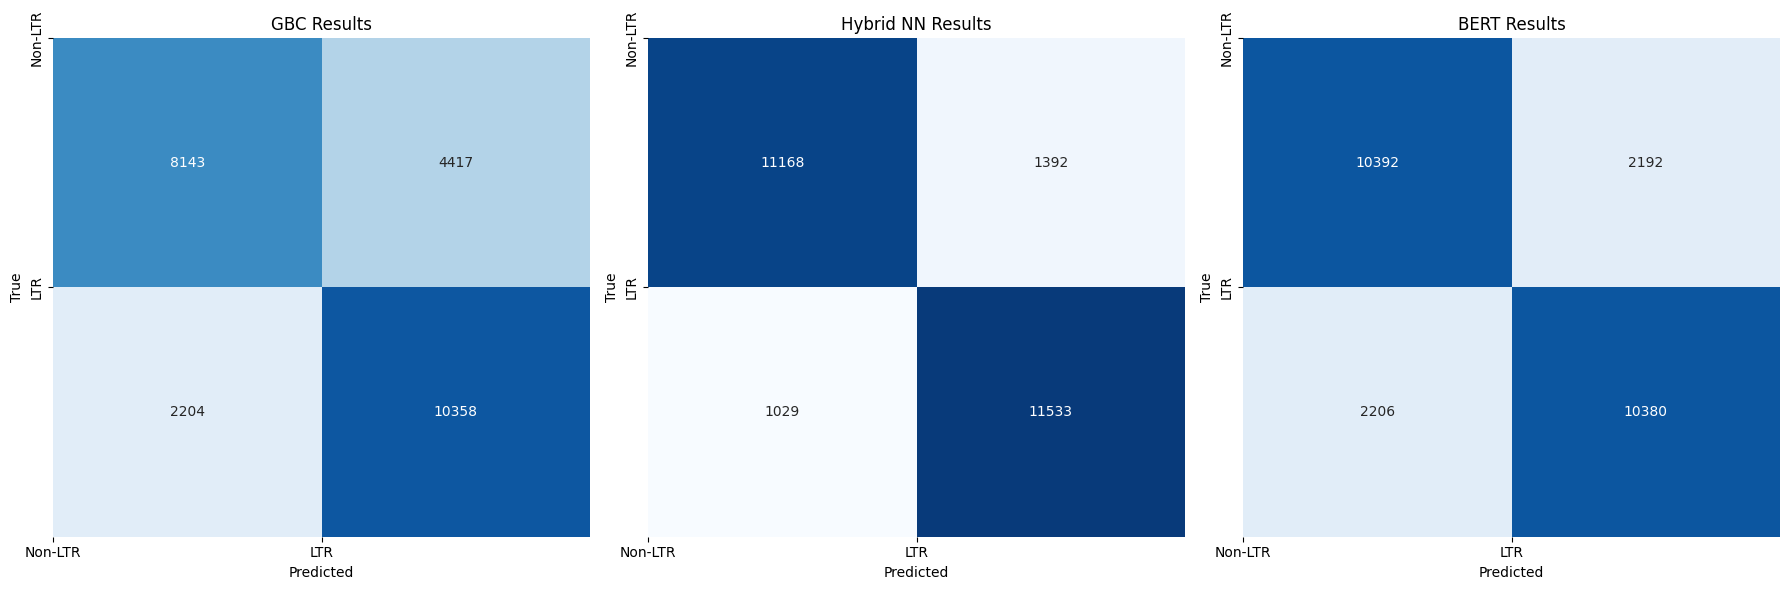

In [60]:
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calculate confusion matrix
cm = confusion_matrix(Y, GBC_predictions)
# Plot GBC results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[0], vmax=12000, vmin=1000)
axes[0].set_title('GBC Results')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Non-LTR', 'LTR'])
axes[0].set_yticklabels(['Non-LTR', 'LTR'])


cm = confusion_matrix(Y, Hybrid_NN_long_predictions)
# Plot Hybrid NN results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[1], vmax=12000, vmin=1000)
axes[1].set_title('Hybrid NN Results')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Non-LTR', 'LTR'])
axes[1].set_yticklabels(['Non-LTR', 'LTR'])

# Calculate confusion matrix
cm = confusion_matrix(labels, long_predictions)
# Plot BERT results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[2], vmax=12000, vmin=1000)
axes[2].set_title('BERT Results')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_xticklabels(['Non-LTR', 'LTR'])
axes[2].set_yticklabels(['Non-LTR', 'LTR'])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

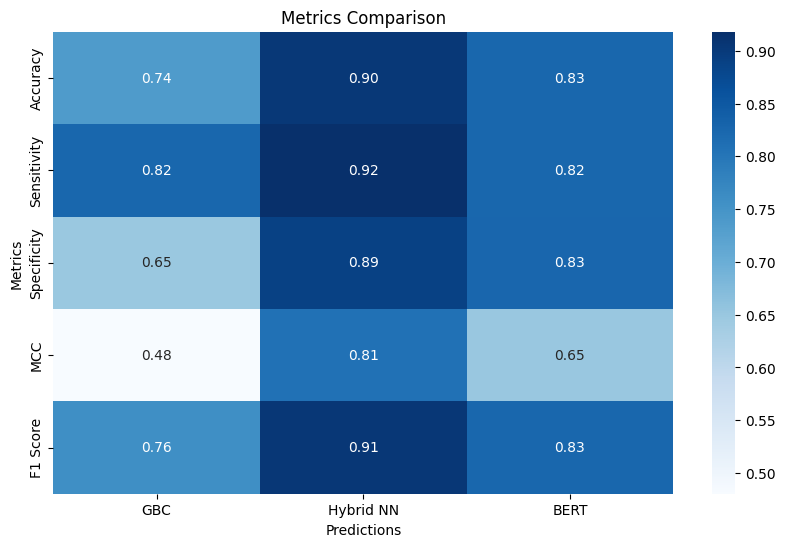

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef, roc_auc_score, f1_score
import matplotlib.pyplot as plt
# Create a list of predictions and labels
Y = [0]*len(non_LTRs) + [1]*len(LTRs)
predictions = [GBC_predictions, Hybrid_NN_long_predictions, long_predictions]
names = ['GBC', 'Hybrid NN', 'BERT']

# Create a list to store the metrics
accuracy_list = []
sensitivity_list = []
specificity_list = []
mcc_list = []
roc_auc_list = []
f1_list = []

# Calculate the metrics for each prediction
for pred, n in zip(predictions, names):
    if n == 'BERT':
        y = labels
    else:
        y = Y
    # Calculate accuracy
    accuracy = accuracy_score(y, pred)
    accuracy_list.append(accuracy)
    
    # Calculate sensitivity (recall)
    sensitivity = recall_score(y, pred)
    sensitivity_list.append(sensitivity)
    
    # Calculate specificity
    specificity = recall_score(y, pred, pos_label=0)
    specificity_list.append(specificity)
    
    # Calculate MCC
    mcc = matthews_corrcoef(y, pred)
    mcc_list.append(mcc)
    
    # Calculate F1 score
    f1 = f1_score(y, pred)
    f1_list.append(f1)

# Create a list of metric lists
metrics_list = [accuracy_list, sensitivity_list, specificity_list, mcc_list, f1_list]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(metrics_list, annot=True, cmap="Blues", fmt=".2f", xticklabels=names, yticklabels=['Accuracy', 'Sensitivity', 'Specificity', 'MCC', 'F1 Score'])
ax.set_title('Metrics Comparison')
ax.set_xlabel('Predictions')
ax.set_ylabel('Metrics')

# Show the plot
plt.show()


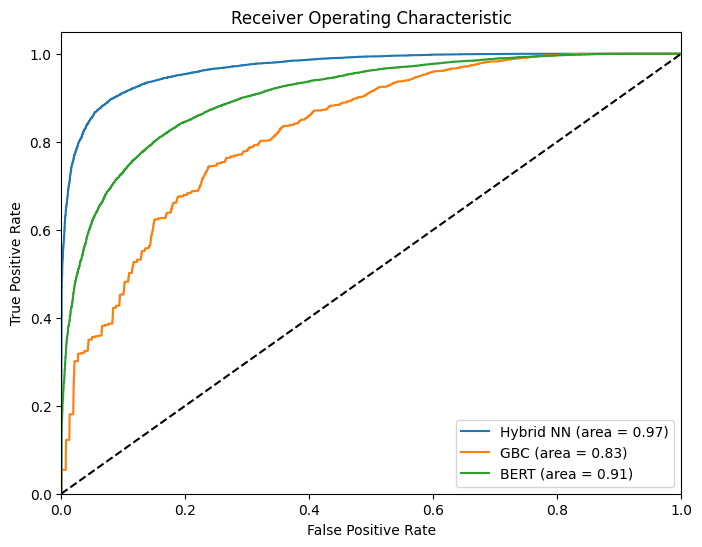

In [67]:
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate and true positive rate for each model
fpr_hybrid, tpr_hybrid, _ = roc_curve(Y, HNN_long_probas)
fpr_gbc, tpr_gbc, _ = roc_curve(Y, GBC.predict_proba(X)[:, 1])
fpr_bert, tpr_bert, _ = roc_curve(labels, predicted_probas_BERT)

# Calculate the area under the ROC curve for each model
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
roc_auc_bert = auc(fpr_bert, tpr_bert)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_hybrid, tpr_hybrid, label="Hybrid NN (area = %0.2f)" % roc_auc_hybrid)
plt.plot(fpr_gbc, tpr_gbc, label="GBC (area = %0.2f)" % roc_auc_gbc)
plt.plot(fpr_bert, tpr_bert, label="BERT (area = %0.2f)" % roc_auc_bert)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [45]:
import numpy as np
predicted_probas_BERT_long = np.load("BERT_predict_probas_long.npy")
HNN_long_probas = np.load("Hybrid_NN_long_probas.npy")
GBC_predict_probas_long = np.load("GBC_predict_probas_long.npy")

predicted_probas_BERT_short = np.load("BERT_predict_probas_short.npy")
HNN_short_probas = np.load("Hybrid_NN_short_predict_probas.npy")
GBC_predict_probas_short = np.load("GBC_predict_probas_short.npy")
Y_all = np.load("Y_all.npy")

In [83]:
# Concatenate the arrays for each model
#predicted_probas_BERT = np.concatenate(predicted_probas_BERT_short[:, 1].reshape(-1, 1), predicted_probas_BERT_long)
predicted_probas_BERT = np.concatenate((np.argmax(predicted_probas_BERT_short, axis=-1).reshape(-1, 1), predicted_probas_BERT_long))

HNN_probas = np.concatenate((HNN_short_probas,HNN_long_probas))
GBC_predict_probas = np.concatenate((GBC_predict_probas_short, GBC_predict_probas_long))

Y_all.shape[0] == predicted_probas_BERT.shape[0] == HNN_probas.shape[0] == RFC_predict_probas.shape[0]

False

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [42]:
BERT_labels = labels + embed_labs.tolist()

In [111]:
HNN_short = np.load("Hybrid_NN_short_predictions.npy")

In [109]:
Y_long_inverted = [1 if val == 0 else 0 for val in Y_long]


In [115]:
Y_all = Y_short + Y_long_inverted

In [132]:
Y_all_GBC = Y_short_GBC.to_list() + Y_long_GBC.to_list()

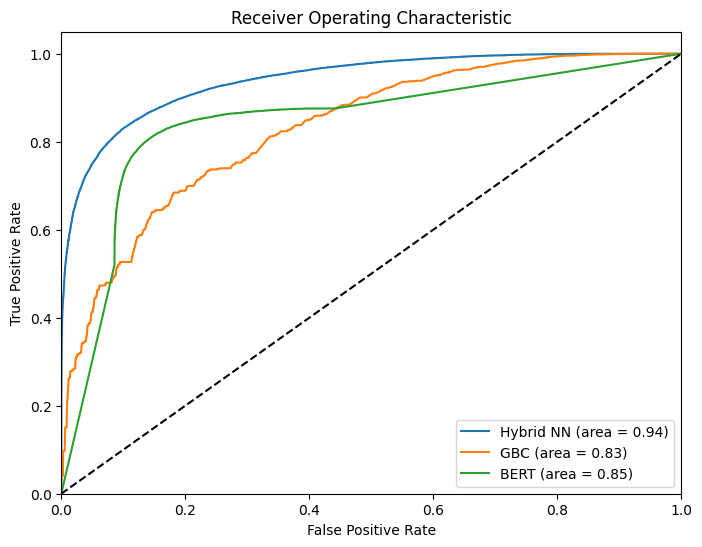

In [137]:
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate and true positive rate for each model
fpr_hybrid, tpr_hybrid, _ = roc_curve(Y_all, HNN_probas)
fpr_gbc, tpr_gbc, _ = roc_curve(Y_all_GBC, GBC_predict_probas[:, 1])
fpr_bert, tpr_bert, _ = roc_curve(BERT_labels, predicted_probas_BERT)

# Calculate the area under the ROC curve for each model
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
roc_auc_bert = auc(fpr_bert, tpr_bert)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_hybrid, tpr_hybrid, label="Hybrid NN (area = %0.2f)" % roc_auc_hybrid)
plt.plot(fpr_gbc, tpr_gbc, label="GBC (area = %0.2f)" % roc_auc_gbc)
plt.plot(fpr_bert, tpr_bert, label="BERT (area = %0.2f)" % roc_auc_bert)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [139]:
BERT_predictions = np.load("BERT_predictions_short.npy").tolist()+np.load("BERT_predictions_long.npy").tolist()
Hybrid_NN_predictions = np.load("Hybrid_NN_short_predictions.npy").tolist()+np.load("Hybrid_NN_long_predictions.npy").tolist()
GBC_predictions = np.load("GBC_predictions_short.npy").tolist()+np.load("GBC_predictions_long.npy").tolist()

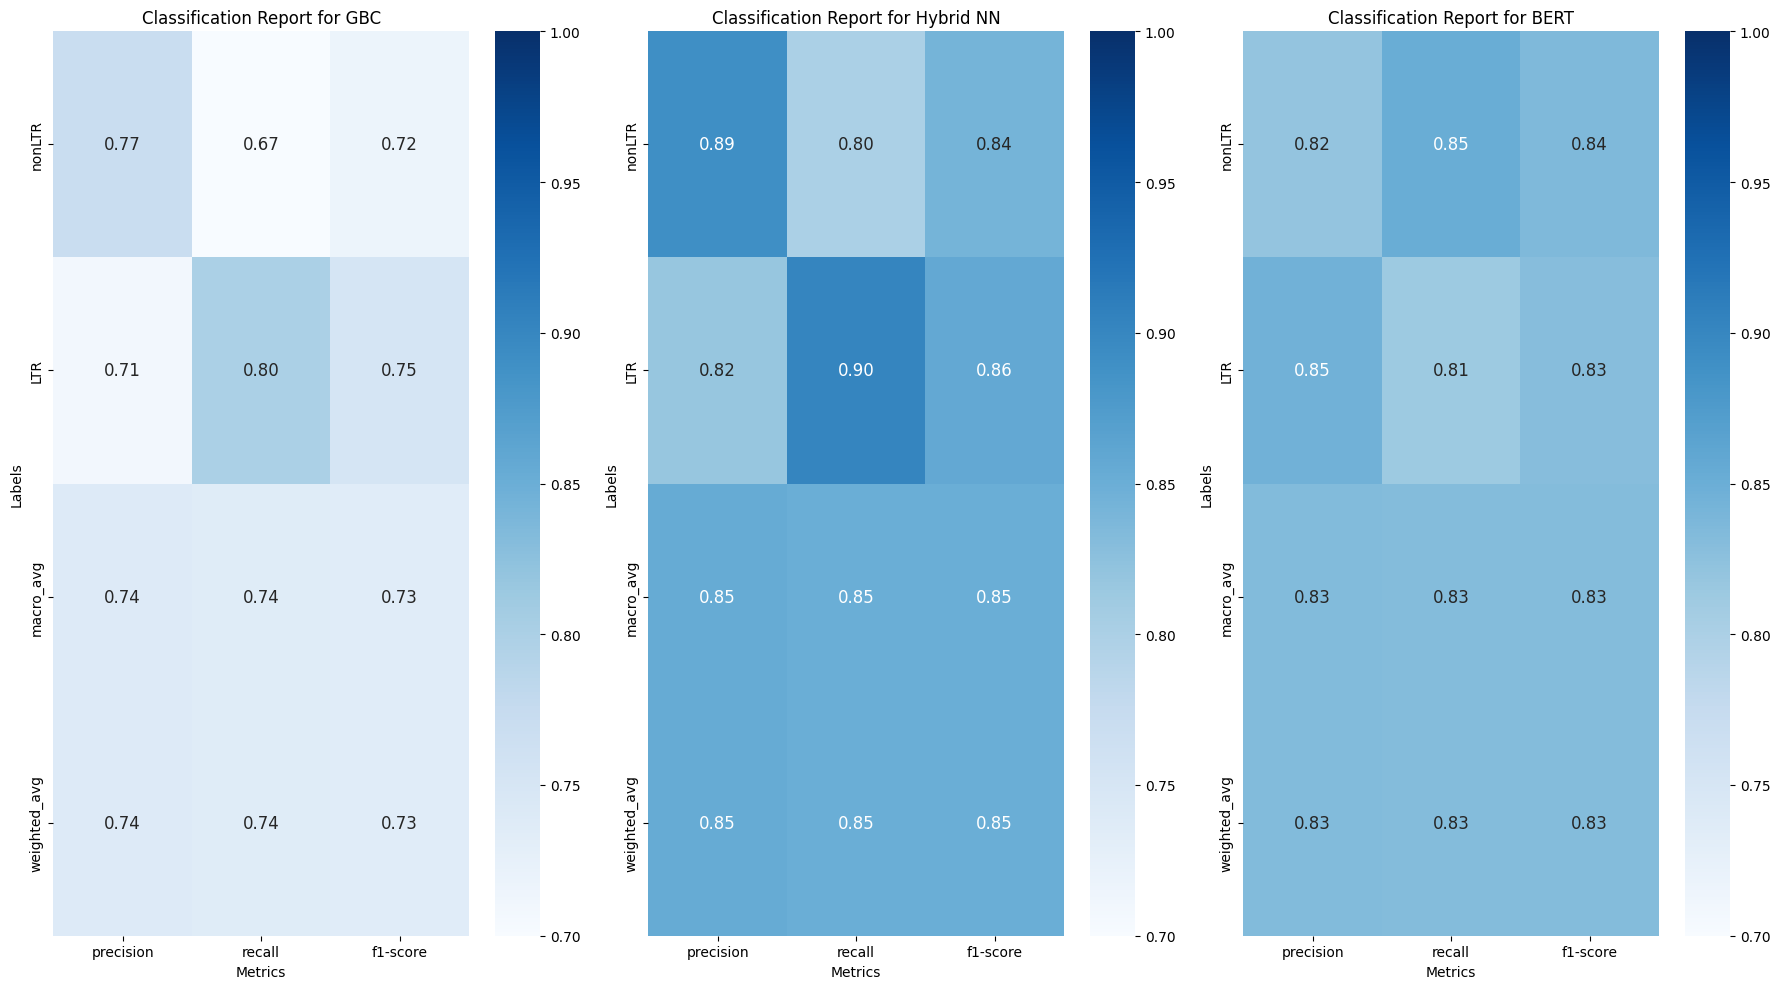

In [140]:
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
# Create a list of predictions and labels
predictions = [GBC_predictions, Hybrid_NN_predictions, BERT_predictions]
names = ['GBC', 'Hybrid NN', 'BERT']

# Create a list to store the classification reports
reports = []

# Generate the classification report for each prediction
for pred, name in zip(predictions, names):
    if name == 'BERT':
        y = BERT_labels
    elif name == 'GBC':
        y = Y_all_GBC
    else:
        y = Y_all
    report = classification_report(y, pred, output_dict=True)
    reports.append(report)

# Plot the classification reports
fig, axes = plt.subplots(1,len(reports), figsize=(6* len(reports), 10))

for i, report in enumerate(reports):
    rep = pd.DataFrame(report).drop("accuracy", axis=1)
    rep.columns = ["nonLTR", "LTR"] + [ "macro_avg", "weighted_avg"]
    rep = rep.T
    rep = rep.drop("support", axis=1)
    #rep["support"] = rep["support"].astype(int)
    
    ax = axes[i]
    sns.heatmap(rep, annot=True, cmap="Blues", cbar=True, ax=ax, vmax=1, vmin=0.7, annot_kws={"size": 12}, fmt=".2f")
    ax.set_title(f"Classification Report for {names[i]}")
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Labels')

plt.tight_layout()
plt.show()


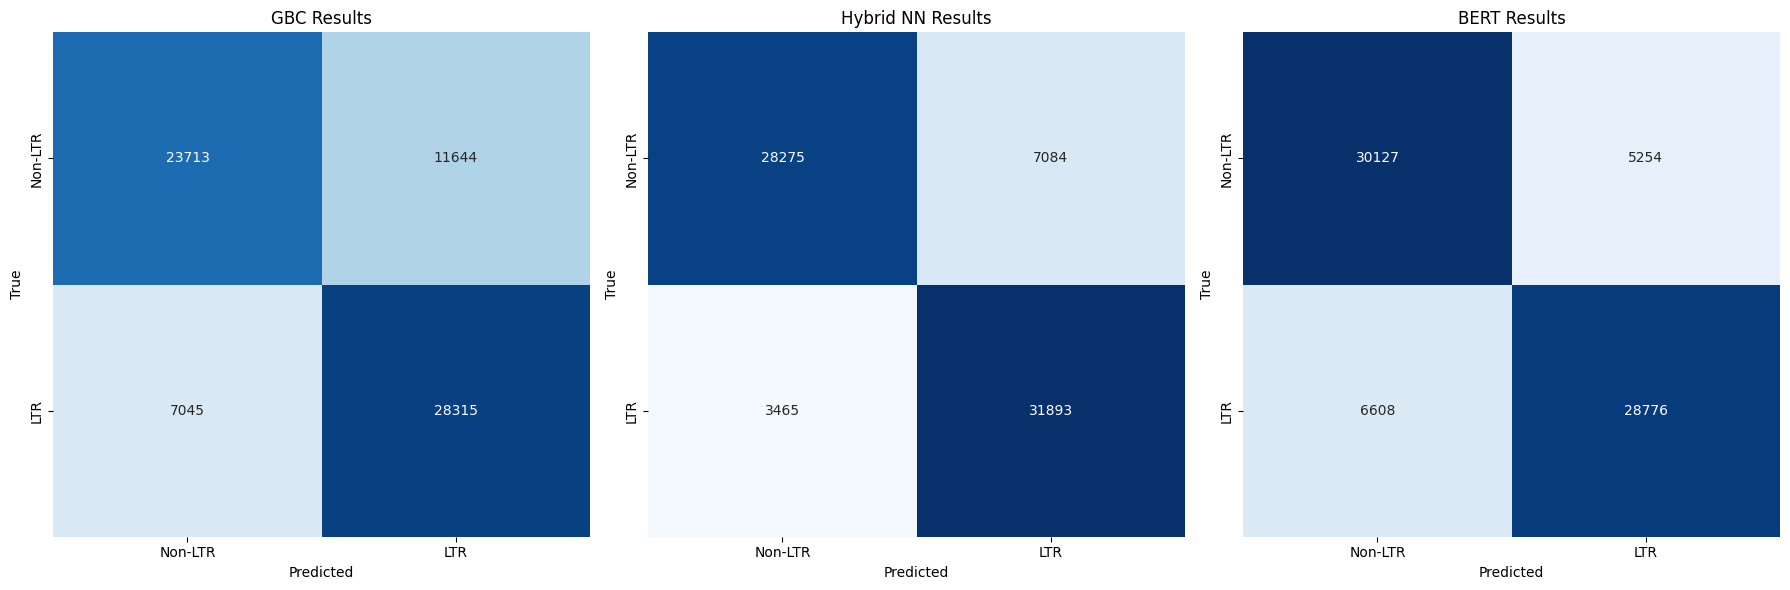

In [148]:
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calculate confusion matrix
cm = confusion_matrix(Y_all_GBC, GBC_predictions)
# Plot GBC results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[0], vmax=30000, vmin=3000)
axes[0].set_title('GBC Results')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[2].set_xticks([0.5, 1.5])  # Center the ticks
axes[2].set_yticks([0.5, 1.5])
axes[0].set_xticklabels(['Non-LTR', 'LTR'])
axes[0].set_yticklabels(['Non-LTR', 'LTR'])


cm = confusion_matrix(Y_all, Hybrid_NN_predictions)
# Plot Hybrid NN results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[1], vmax=30000, vmin=3000)
axes[1].set_title('Hybrid NN Results')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[2].set_xticks([0.5, 1.5])  # Center the ticks
axes[2].set_yticks([0.5, 1.5])
axes[1].set_xticklabels(['Non-LTR', 'LTR'])
axes[1].set_yticklabels(['Non-LTR', 'LTR'])

# Calculate confusion matrix
cm = confusion_matrix(BERT_labels, BERT_predictions)
# Plot BERT results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[2], vmax=30000, vmin=3000)
axes[2].set_title('BERT Results')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_xticks([0.5, 1.5])  # Center the ticks
axes[2].set_yticks([0.5, 1.5])
axes[2].set_xticklabels(['Non-LTR', 'LTR'])
axes[2].set_yticklabels(['Non-LTR', 'LTR'])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()